In [1]:
import pandas as pd
from astral.sun import sun
from astral import LocationInfo

LOCATION = (51.365967, 6.172045) # Venlo, NL

#TZ= "Europe/Amsterdam"
from datetime import datetime, time, timedelta

T_MIN = time(7,0) # minimum time
RISE_OFFSET = timedelta(minutes=20)
SET_OFFSET = timedelta(minutes=35)


def time_to_decimal(t):
    """Convert time to decimal hours."""
    return t.hour + t.minute / 60 + t.second / 3600


def calculate_sun_times(latitude, longitude, tz= "UTC"):
    """Calculates sunrise and sunset times and returns them as time objects."""
    # Define the location
    location = LocationInfo(latitude=latitude, longitude=longitude)

    # Create a pandas DataFrame to hold sunrise and sunset times
    date_range = pd.date_range(start="2024-01-15", end="2030-12-31")
    sunrise_times = []
    sunset_times = []

    for day in date_range:
        s = sun(location.observer, date=day, tzinfo=tz)
        sunrise_times.append(s['sunrise'])
        sunset_times.append(s['sunset'])

    # Create DataFrame
    df = pd.DataFrame(index=date_range, data={'rise': sunrise_times, 'set': sunset_times})
    return df




In [2]:
t_local = calculate_sun_times(*LOCATION, tz = "Europe/Amsterdam")

t_local["rise"] = t_local["rise"]+ RISE_OFFSET
t_local["set"] = t_local["set"] + SET_OFFSET

# remove date
t_local = t_local.map(lambda v : v.time())


In [3]:
# limit morning time
s = t_local.rise
s[s<T_MIN] = T_MIN

t_local

,rise,set
2024-01-15,08:54:25.427274,17:30:03.438840
2024-01-16,08:53:35.455970,17:31:36.481192
2024-01-17,08:52:42.613437,17:33:11.029511
2024-01-18,08:51:46.948518,17:34:46.999848
2024-01-19,08:50:48.511225,17:36:24.309265
...,...,...
2030-12-27,09:00:19.467502,17:07:28.737382
2030-12-28,09:00:29.494737,17:08:18.397997
2030-12-29,09:00:36.171618,17:09:11.033117
2030-12-30,09:00:39.493963,17:10:06.582308


In [4]:
t_utc = calculate_sun_times(*LOCATION, tz = "UTC")

t_utc

,rise,set
2024-01-15,2024-01-15 07:34:25.427274+00:00,2024-01-15 15:55:03.438840+00:00
2024-01-16,2024-01-16 07:33:35.455970+00:00,2024-01-16 15:56:36.481192+00:00
2024-01-17,2024-01-17 07:32:42.613437+00:00,2024-01-17 15:58:11.029511+00:00
2024-01-18,2024-01-18 07:31:46.948518+00:00,2024-01-18 15:59:46.999848+00:00
2024-01-19,2024-01-19 07:30:48.511225+00:00,2024-01-19 16:01:24.309265+00:00
...,...,...
2030-12-27,2030-12-27 07:40:19.467502+00:00,2030-12-27 15:32:28.737382+00:00
2030-12-28,2030-12-28 07:40:29.494737+00:00,2030-12-28 15:33:18.397997+00:00
2030-12-29,2030-12-29 07:40:36.171618+00:00,2030-12-29 15:34:11.033117+00:00
2030-12-30,2030-12-30 07:40:39.493963+00:00,2030-12-30 15:35:06.582308+00:00


In [5]:
# convert to utc
import pytz
from datetime import datetime

# Define a function to convert to UTC
amsterdam_tz = pytz.timezone('Europe/Amsterdam')

def to_utc(time_obj, date):
    local_dt = amsterdam_tz.localize(datetime.combine(date, time_obj))
    utc_dt = local_dt.astimezone(pytz.utc)
    return utc_dt.time()

# Apply the conversion
df = t_local
df['open'] = list(map(to_utc, df['rise'], df.index))
df['close'] = list(map(to_utc, df['set'], df.index))


<Axes: >

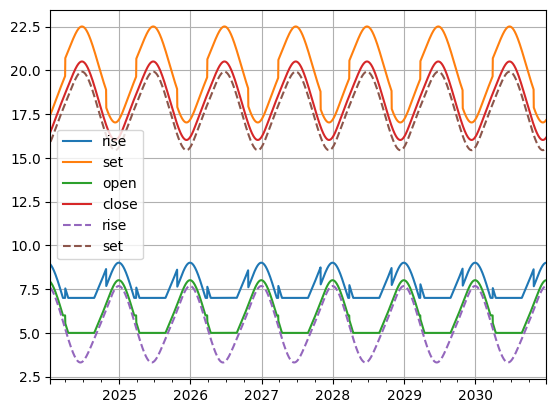

In [6]:
ax = df.map(time_to_decimal).plot()
t_utc.map(time_to_decimal).plot(ax=ax, style='--',grid=True)

In [7]:
lut = df[["open","close"]].map(time_to_decimal)
lut.to_csv("sun_lut.csv", float_format = "%.2f",header=None)